In [1]:
! pip install scikit-learn==1.3.2

In [56]:
import re
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, RandomSampler, WeightedRandomSampler
import torch
from torch import cuda
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, AdamW
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer
from google.colab import files
from tqdm import tqdm
tqdm.pandas()
from sklearn import metrics
import warnings
import seaborn as sns
from collections import defaultdict
import sklearn
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
MODEL_CHECKPOINT = "bert-base-uncased"
TOKENIZE_REGEX = r"[\w]+|[.,!?;']"
NULL_ENTITY = "NULL"
NA_LABEL = "NA"
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [4]:
uploaded = files.upload()

Saving train.csv to train (1).csv


In [5]:
uploaded = files.upload()

Saving test.csv to test (1).csv


In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [7]:
train_df["dataset"] = "train"
test_df["dataset"] = "test"

df = pd.concat([train_df, test_df])
df["id"] = range(len(df))
df["labels"] = df["labels"].apply(eval)
df["text"] = df["text"].str.replace(" '", "'")


In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

In [10]:
def tokenize(text):
  return re.findall(TOKENIZE_REGEX, text)

def create_tag(aspect, sentiment):
  return f"{aspect}_{sentiment}"


def create_labels(labels):
  return [{"entity": entity, "tokens": tokenize(entity),
                             "aspect": aspect, "sentiment": sentiment,
                             "net_tag": create_tag(aspect, sentiment)
                             } for (entity, aspect, sentiment) in labels]


def get_ner_tokens_indexes(tokens, labels_fixed):

    tokens_with_indexes = []

    for label in labels_fixed:
        label_tokens = label["tokens"]
        net_tag = label["net_tag"]

        if label["entity"] == NULL_ENTITY:
            continue

        run_index = 0
        had_match = False
        while run_index < len(tokens):
            if tokens[run_index: run_index + len(label_tokens)] == label_tokens:
                had_match = True

                start = run_index
                end = run_index + len(label_tokens) - 1
                tokens_with_indexes.append({"start": start, "end": end, "tag": net_tag,
                                        "label_tokens": label_tokens})
                break
            else:
                run_index += 1

        if not had_match:
            raise Exception(f"not match {label_tokens}")

    return tokens_with_indexes

def get_tokens_labels(ner_tokens, tokens):

    if len(ner_tokens) == 0:
        return None

    index_to_label = defaultdict(lambda: [])

    for ner_token in ner_tokens:
        start = ner_token["start"]
        end = ner_token["end"]

        for i in range(start, end + 1):
          index_to_label[i].append(ner_token["tag"])

    labels = [index_to_label[i] if len(index_to_label[i]) > 0 else [NA_LABEL] for i in range(len(tokens))]

    return labels

In [11]:
df["tokens"] = df["text"].apply(tokenize)

<Axes: xlabel='num_of_tokens', ylabel='count'>

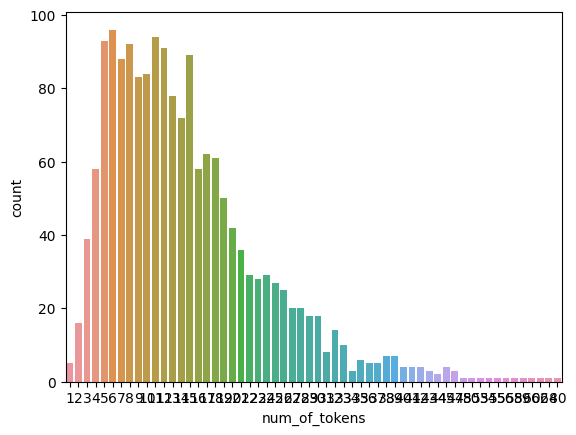

In [12]:
df["num_of_tokens"] = df["tokens"].apply(len)

sns.countplot(df, x="num_of_tokens")

In [13]:
df["labels_fixed"] = df["labels"].apply(create_labels)

In [14]:
df["ner_tokens"] = df.apply(lambda r: get_ner_tokens_indexes(r["tokens"], r["labels_fixed"]) ,axis=1)

In [15]:
df["tokens_labels"] = df.apply(lambda r: get_tokens_labels(r["ner_tokens"], r["tokens"]),axis=1)

In [16]:
df.groupby(["dataset"]).size()

dataset
test      582
train    1120
dtype: int64

In [17]:
df = df[df["tokens_labels"].notnull()]
df.groupby(["dataset"]).size()

dataset
test     401
train    833
dtype: int64

In [18]:
train_df = df[df["dataset"] == "train"]
test_df = df[df["dataset"] == "test"]

unique_labels = set()
for row_tokens in train_df["tokens_labels"].tolist():
  unique_labels.update({token for word_tokens in row_tokens for token in word_tokens})

unique_labels = sorted(unique_labels)

len(train_df), len(test_df), len(unique_labels), unique_labels[0]

(833, 401, 33, 'NA')

In [19]:
#remove label that we didnt train on (exist in test bit not in train for now - maybe with threshold in the future)
def clean_labels(tokens_labels):
  new_labels = []
  for labels in tokens_labels:
    fixed_labels = [label for label in labels if label in unique_labels]
    if len(fixed_labels) == 0:
      fixed_labels = [NA_LABEL]
    new_labels.append(fixed_labels)

  return new_labels

In [20]:
train_df["tokens_labels"] = train_df["tokens_labels"].apply(clean_labels)
test_df["tokens_labels"] = test_df["tokens_labels"].apply(clean_labels)

In [21]:
label_to_id = {l:i for  (i,l) in enumerate(unique_labels)}
id_to_label = {y:x for (x,y) in label_to_id.items()}

na_id = label_to_id[NA_LABEL]

len(label_to_id), len(id_to_label), label_to_id[NA_LABEL], id_to_label[label_to_id[NA_LABEL]], label_to_id["food quality_negative"]

(33, 33, 0, 'NA', 14)

In [22]:
class NERBertModel(nn.Module):

    def __init__(self, num_tag, bert_model = MODEL_CHECKPOINT, bert_dropout = 0.3):
        super(NERBertModel, self).__init__()
        self.num_tag = num_tag
        self.bert = BertModel.from_pretrained(bert_model).to(device)
        self.bert_drop = nn.Dropout(bert_dropout)
        self.out_tag = nn.Linear(768, self.num_tag)
        self._init_weights()

    def forward(self, ids, mask, token_type_ids):

        output, _ = self.bert(ids, attention_mask=mask, return_dict=False)

        bert_out = self.bert_drop(output)
        out = self.out_tag(bert_out)

        return out

    def _init_weights(self):
      torch.nn.init.xavier_uniform(self.out_tag.weight)
      self.out_tag.bias.data.fill_(0.01)


class NerDataset(Dataset):

    def __init__(self, df):
        self._df = df

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        row = self._df.iloc[idx]
        input_ids = np.array(row["input_ids"])
        attention_mask = np.array(row["attention_mask"])
        valid_by_attension = np.where(attention_mask == 1)[0]
        labels = row["labels"]
        non_na_indexes = np.where(labels != label_to_id['NA'])[0]
        number_of_not_na = non_na_indexes.shape[0]
        valid_indexes = sorted(set(np.where(labels == label_to_id['NA'])[0]).intersection(set(valid_by_attension)))
        selected_train_indexes = np.random.choice(valid_indexes, min(len(valid_indexes), int(non_na_indexes.shape[0] * 2)), replace = False)
        non_train_indexes = np.array(list(set(valid_indexes) - set(selected_train_indexes)))
        train_attention_mask = np.array(attention_mask, copy=True)
        if non_train_indexes.shape[0] > 0:
          train_attention_mask[non_train_indexes] = 0
        binay_labels = np.zeros(shape=(input_ids.shape[0], len(label_to_id)))
        for (i, ll) in enumerate(labels):
          binay_labels[i][ll] = 1
        return input_ids, row["token_type_ids"], attention_mask, binay_labels, train_attention_mask


def collate_fn(batch):

    max_length_in_batch = max([len(row[0]) for row in batch])
    input_ids = torch.stack([torch.from_numpy(np.concatenate([row[0], np.full(max_length_in_batch - len(row[0]), fill_value=0)])) for row in batch])
    token_type_ids = torch.stack([torch.from_numpy(np.concatenate([row[1], np.full(max_length_in_batch - len(row[1]), fill_value=0)])) for row in batch])
    attention_mask = torch.stack([torch.from_numpy(np.concatenate([row[2], np.full(max_length_in_batch - len(row[2]), fill_value=0)])) for row in batch])
    labels = torch.stack([torch.from_numpy(np.concatenate([row[3], np.zeros(shape=(max_length_in_batch - len(row[3]), len(id_to_label)))])) for row in batch])
    train_attention_mask = torch.stack([torch.from_numpy(np.concatenate([row[4], np.full(max_length_in_batch - len(row[4]), fill_value=0)])) for row
            in batch])

    return input_ids, token_type_ids, attention_mask, labels, train_attention_mask

In [24]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id is None:
            new_labels.append([label_to_id[NA_LABEL]])
        elif word_id != current_word:
            current_word = word_id
            new_labels.append(labels[word_id])
        else:
            new_labels.append(labels[word_id])

    return new_labels

def tokenize_and_align_labels(dataset):

    tokenized_inputs = tokenizer(dataset["words"], padding = False, truncation=False, is_split_into_words=True)
    new_labels = []
    for i, labels in enumerate(dataset["labels"]):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    tokenized_inputs["texts"] = dataset["words"]

    return tokenized_inputs



In [25]:
train_df["labels_ids"] = train_df["tokens_labels"].apply(lambda tokens_labels: [[label_to_id[x] for x in token_labels] for token_labels in tokens_labels])
test_df["labels_ids"] = test_df["tokens_labels"].apply(lambda tokens_labels: [[label_to_id[x] for x in token_labels] for token_labels in tokens_labels])

In [26]:
train_tokens = train_df["tokens"].tolist()
train_labels_ids = train_df["labels_ids"].tolist()
train_data = {"words": train_tokens, "labels": train_labels_ids}

train_datasets = tokenize_and_align_labels(train_data)

In [27]:
test_tokens = test_df["tokens"].tolist()
test_labels_ids = test_df["labels_ids"].tolist()
test_data = {"words": test_tokens, "labels": test_labels_ids}

test_datasets = tokenize_and_align_labels(test_data)

In [28]:
def dataset_to_df(dataset):
  rows = [(dataset["input_ids"][i], dataset["token_type_ids"][i],dataset["attention_mask"][i],dataset["labels"][i], dataset["texts"][i]) for i in range(len(dataset["input_ids"]))]

  return pd.DataFrame(rows,
                          columns = ["input_ids", "token_type_ids", "attention_mask", "labels", "texts"])



In [29]:
train_dataset_df = dataset_to_df(train_datasets)
test_dataset_df = dataset_to_df(test_datasets)

len(train_dataset_df), len(test_dataset_df)

(833, 401)

In [43]:
def eval_model(loader):
  model.eval()
  all_preds = []
  all_labels = []

  loss = 0.
  total_preds = 0.
  same = 0.
  with torch.no_grad():
    count = 0.
    for input_ids, token_type_ids, attention_mask, labels, train_attention_mask  in loader:

      input_ids = input_ids.to(device)
      token_type_ids = token_type_ids.to(device)
      attention_mask = attention_mask.to(device)
      labels = labels.to(device)

      predictions = model(input_ids, attention_mask, token_type_ids)
      count += input_ids.shape[0]

      loss  += criterion(predictions, labels)


      scores = torch.sigmoid(predictions).detach().cpu().gt(0.5).numpy()
      batch_same = np.sum(labels.detach().cpu().numpy() == scores)
      batch_total = labels.detach().cpu().numpy().size

      same += batch_same
      total_preds += batch_total

  return loss/count, same/total_preds

def eval_and_plot(loader, dataset_name, epoc_number):

  loss, accuracy  = eval_model(loader)

  print(f"\n {dataset_name} Epoc {epoc_number} loss {loss} accuracy {accuracy}")


In [32]:
def plot_labels_counts(df):

  labels_df = df[["labels"]]
  labels_df["id"] = range(len(labels_df))
  labels_df = labels_df.explode("labels").explode("labels").rename(columns= {"labels": "label"})

  labels_df = labels_df.drop_duplicates()
  sns.countplot(labels_df, x="label")


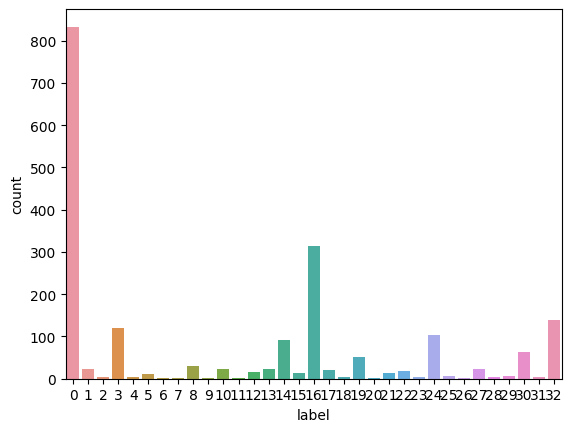

In [33]:
plot_labels_counts(train_dataset_df)


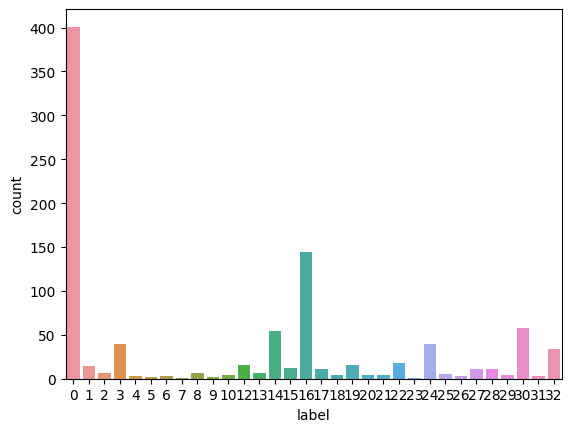

In [34]:
plot_labels_counts(test_dataset_df)

In [35]:
#calculate weight based on labels distribution
train_labels_df = train_dataset_df[["labels"]]
train_labels_df["id"] = range(len(train_labels_df))
train_labels_df = train_labels_df.explode("labels").explode("labels").rename(columns= {"labels": "label"})
train_labels_df = train_labels_df.drop_duplicates()
label_count_df = train_labels_df.groupby(["label"]).size().to_frame("number_of_rows").reset_index()
label_count_df
label_to_count = dict(zip(label_count_df.label, label_count_df.number_of_rows))
train_dataset_df["weight"] = train_dataset_df["labels"].apply(lambda row_labels: max([max(1./label_to_count[label] for label in labels) for labels in row_labels]))


<Axes: xlabel='weight', ylabel='Count'>

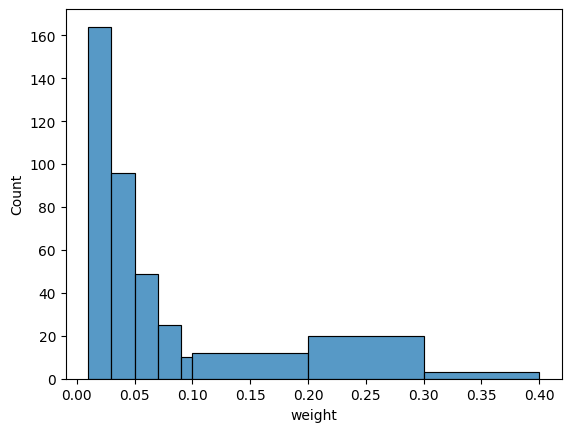

In [36]:
sns.histplot(data=train_dataset_df, x="weight", bins=[0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.4])

In [37]:
BATCH_SIZE = 16
#sampler = WeightedRandomSampler(train_dataset_df["weight"].tolist(), len(train_dataset_df), replacement = False)
train_dataset = NerDataset(train_dataset_df)
sampler = RandomSampler(train_dataset)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn, sampler=sampler)
train_eval_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, collate_fn=collate_fn)
test_dataset = NerDataset(test_dataset_df)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn)

len(train_data_loader), len(test_data_loader)

(53, 26)

In [38]:
#loss pos weights by label

num_if_words = np.sum(train_dataset_df["input_ids"].map(len))
words_labels =[words_label for text_labels in train_dataset_df["labels"].tolist() for words_label in text_labels]
all_labels = [label for word_labels in words_labels for label in word_labels]
pos_counts = np.bincount(all_labels)
negative_counts = num_if_words - pos_counts
pos_weights = negative_counts/pos_counts
pos_weights

array([1.69297644e-01, 4.37085714e+02, 2.18942857e+03, 6.68451327e+01,
       3.06560000e+03, 9.00941176e+02, 1.53320000e+04, 1.53320000e+04,
       2.63362069e+02, 3.83225000e+03, 2.88301887e+02, 2.55450000e+03,
       6.65652174e+02, 3.32326087e+02, 6.39703390e+01, 6.12320000e+02,
       1.56663043e+01, 3.92153846e+02, 1.17846154e+03, 1.33500000e+02,
       1.53320000e+04, 6.12320000e+02, 5.46607143e+02, 3.83225000e+03,
       8.23315217e+01, 1.70266667e+03, 1.53320000e+04, 5.46607143e+02,
       2.55450000e+03, 1.39290909e+03, 1.93088608e+02, 3.06560000e+03,
       9.48312500e+01])

In [44]:
model = NERBertModel(len(label_to_id), bert_dropout = 0.5).to(device)

optimizer = torch.optim.SGD(model.parameters(), weight_decay = 0.0001, lr = 0.0001, nesterov = False, momentum = 0.9)
#optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
#optimizer = torch.optim.SGD(model.parameters(), weight_decay = 0.0001, lr = 0.001, nesterov = False, momentum = 0.9)
#optim = torch.optim.Adam(model.parameters(), lr=0.0001)

pos_weight = torch.FloatTensor (pos_weights).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight= pos_weight)
#criterion = torch.nn.BCEWithLogitsLoss()

In [45]:
NUMBER_OF_EPOCHS = 10 #100
NUMBER_OF_EPOCHS

10

In [51]:
def train(model, number_of_epoc, criterion, optimizer, activae_labels_lost):

  for epoc_number in tqdm(range(number_of_epoc), total = number_of_epoc):

    model.train()
    total_loss = 0.

    for input_ids, token_type_ids, attention_mask, labels, train_attention_mask in train_data_loader:

      model.zero_grad()

      input_ids = input_ids.to(device)
      token_type_ids = token_type_ids.to(device)
      attention_mask = attention_mask.to(device)
      labels = labels.to(device)
      train_attention_mask = train_attention_mask.to(device)


      predictions = model(input_ids, attention_mask, token_type_ids)

      if not activae_labels_lost:
        loss = criterion(predictions, labels)
      else:
        #todo try this option - train on some of the words in every batch - limit NA label:
        active_predictions = predictions[train_attention_mask.gt(0)]
        active_labels = labels[train_attention_mask.gt(0)]
        loss = criterion(active_predictions, active_labels)

      total_loss += loss
      loss.backward()
      optimizer.step()

    eval_and_plot(train_eval_data_loader, "Train", epoc_number)
    eval_and_plot(test_data_loader, "Test", epoc_number)


In [52]:
model = NERBertModel(len(label_to_id), bert_dropout = 0.5).to(device)

optimizer = torch.optim.SGD(model.parameters(), weight_decay = 0.0001, lr = 0.0001, nesterov = False, momentum = 0.9)
#optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
#optimizer = torch.optim.SGD(model.parameters(), weight_decay = 0.0001, lr = 0.001, nesterov = False, momentum = 0.9)
#optim = torch.optim.Adam(model.parameters(), lr=0.0001)

pos_weight = torch.FloatTensor (pos_weights).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight= pos_weight)
#criterion = torch.nn.BCEWithLogitsLoss()

train(model, NUMBER_OF_EPOCHS, criterion, optimizer, False)

  0%|          | 0/10 [00:00<?, ?it/s]


 Train Epoc 0 loss 0.06628983637172992 accuracy 0.5551564395079291


 10%|█         | 1/10 [00:10<01:36, 10.77s/it]


 Test Epoc 0 loss 0.09846346336543697 accuracy 0.5539738709752254

 Train Epoc 1 loss 0.06246099156437126 accuracy 0.607362527945293


 20%|██        | 2/10 [00:20<01:21, 10.23s/it]


 Test Epoc 1 loss 0.0966423872169157 accuracy 0.605739391441058

 Train Epoc 2 loss 0.06062066971199535 accuracy 0.6604647729258417


 30%|███       | 3/10 [00:30<01:10, 10.12s/it]


 Test Epoc 2 loss 0.09522923075390168 accuracy 0.6579956564645334

 Train Epoc 3 loss 0.05706843718287485 accuracy 0.7145930798685087


 40%|████      | 4/10 [00:40<01:00, 10.11s/it]


 Test Epoc 3 loss 0.09524889546569727 accuracy 0.7099985188436988

 Train Epoc 4 loss 0.05940220677938095 accuracy 0.764249290361476


 50%|█████     | 5/10 [00:50<00:50, 10.05s/it]


 Test Epoc 4 loss 0.09438588563274632 accuracy 0.760661202449083

 Train Epoc 5 loss 0.0667892541566834 accuracy 0.8118474815331821


 60%|██████    | 6/10 [01:00<00:39, 10.00s/it]


 Test Epoc 5 loss 0.09405918046640155 accuracy 0.8080724802943754

 Train Epoc 6 loss 0.051608392062995084 accuracy 0.8496925378095397


 70%|███████   | 7/10 [01:10<00:30, 10.09s/it]


 Test Epoc 6 loss 0.09452937627136766 accuracy 0.846921604003048

 Train Epoc 7 loss 0.04892998170968311 accuracy 0.8731156802564033


 80%|████████  | 8/10 [01:22<00:21, 10.58s/it]


 Test Epoc 7 loss 0.09499591423475563 accuracy 0.8695565275272006

 Train Epoc 8 loss 0.04794151741255014 accuracy 0.887713748113227


 90%|█████████ | 9/10 [01:34<00:11, 11.12s/it]


 Test Epoc 8 loss 0.094654389852972 accuracy 0.8882637100645463

 Train Epoc 9 loss 0.045510033819308474 accuracy 0.899186209991711


100%|██████████| 10/10 [01:45<00:00, 10.55s/it]


 Test Epoc 9 loss 0.09432929370169275 accuracy 0.8982748990404605


In [53]:
def evaluate_model(model, threshols, data_loader):

  model.eval()

  rows = []
  with torch.no_grad():
    for input_ids, token_type_ids, attention_mask, labels, train_attention_mask  in tqdm(data_loader, total = len(data_loader), desc = "pred"):

      input_ids = input_ids.to(device)
      token_type_ids = token_type_ids.to(device)
      attention_mask = attention_mask.to(device)

      logits = model(input_ids, attention_mask, token_type_ids)
      labels = labels.numpy()
      scores = torch.sigmoid(logits).detach().cpu().numpy()

      for i in range(scores.shape[-1]):
        label_batch_scores = scores[:, :, i].flatten()
        label_batch_labels = labels[:, :, i].flatten()

        rows.extend(zip([i for _ in range(len(label_batch_scores))], label_batch_scores, label_batch_labels))

  preds_df = pd.DataFrame(rows, columns = ["label_id", "score", "label"])

  precision_recall_rows = []
  for (label, label_id) in tqdm(label_to_id.items(), total = len(label_to_id), desc = "metrics"):

    label_preds = preds_df[preds_df["label_id"] == label_id]

    for th in threshols:

      y = label_preds["label"]
      scores = label_preds["score"]
      predicted_value_after_threshold = np.where(scores < th,0, 1)
      precision = metrics.precision_score(y, predicted_value_after_threshold)
      recall = metrics.recall_score(y, predicted_value_after_threshold)
      accuracy = metrics.accuracy_score(y, predicted_value_after_threshold)
      f1_score = metrics.f1_score(y, predicted_value_after_threshold)


      precision_recall_rows.append((label, label_id, th, precision, recall, accuracy, f1_score))

  metrics_df = pd.DataFrame(precision_recall_rows, columns = ["label", "label_id", "th", "precision", "recall", "accuracy", "f1_score"])

  return metrics_df


def plot_metrics(metrics_df):

  labels_ids = list(pd.unique(metrics_df["label_id"]))#[0:10]

  f, axes = plt.subplots(len(labels_ids), 3, figsize=(8, 40))

  for (i,label_id) in enumerate(labels_ids):

    label_metrics_df = metrics_df[metrics_df["label_id"] == label_id]
    label = label_metrics_df.iloc[0]["label"]
    sns.scatterplot(data=label_metrics_df, x="precision", y="recall", ax = axes[i][0])
    sns.scatterplot(data=label_metrics_df, x="th", y="f1_score", ax = axes[i][1])
    sns.scatterplot(data=label_metrics_df, x="th", y="accuracy", ax = axes[i][2])

  f.tight_layout()
  plt.show()


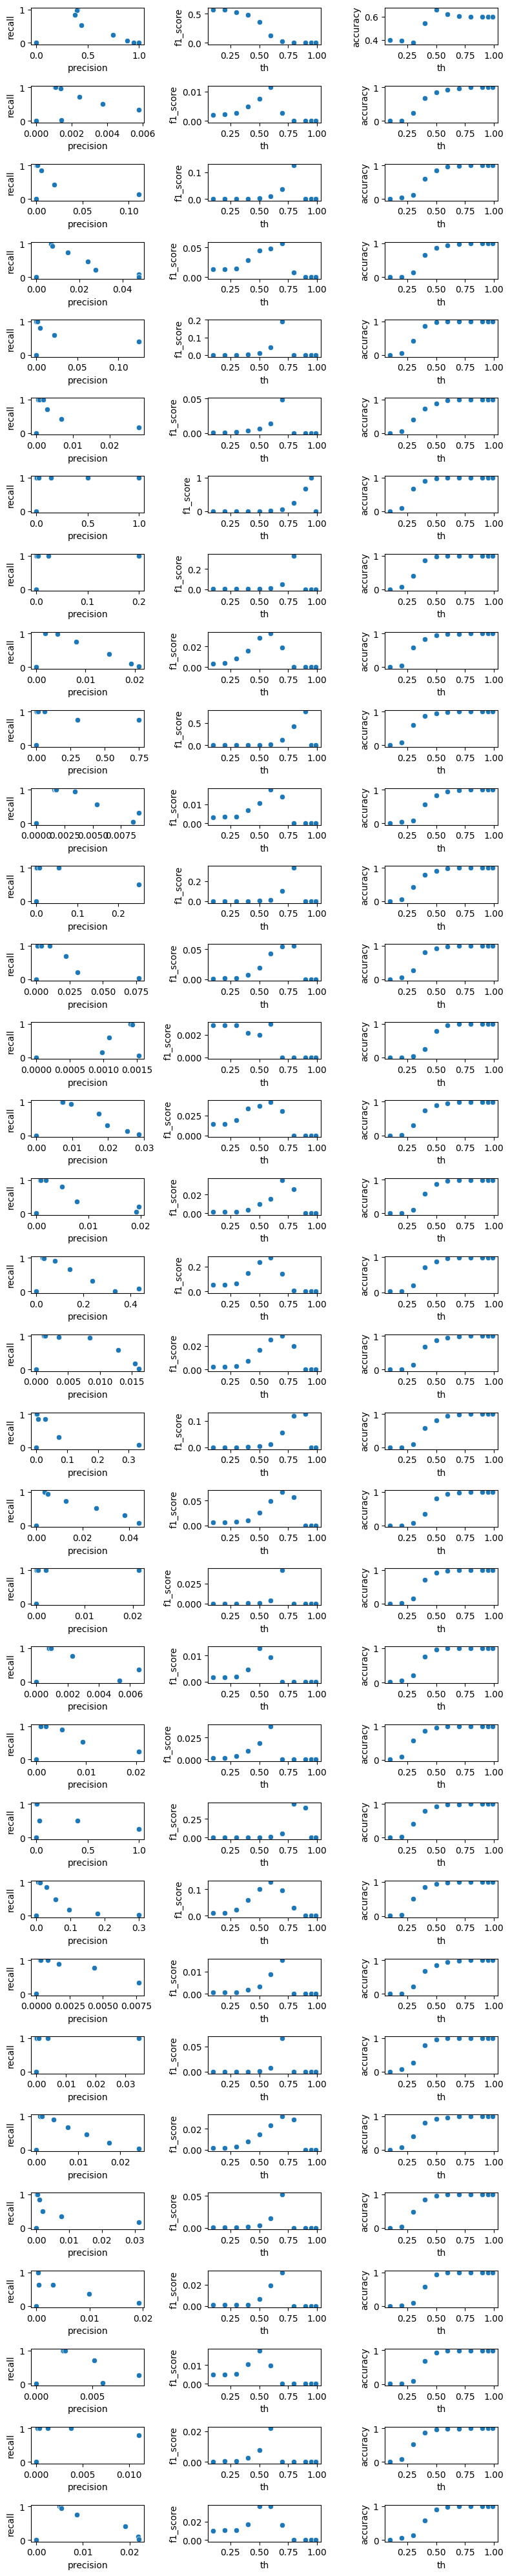

In [57]:
train_metrics_df = evaluate_model(model, thresholds, train_eval_data_loader)
plot_metrics(train_metrics_df)

metrics: 100%|██████████| 33/33 [00:14<00:00,  2.22it/s]


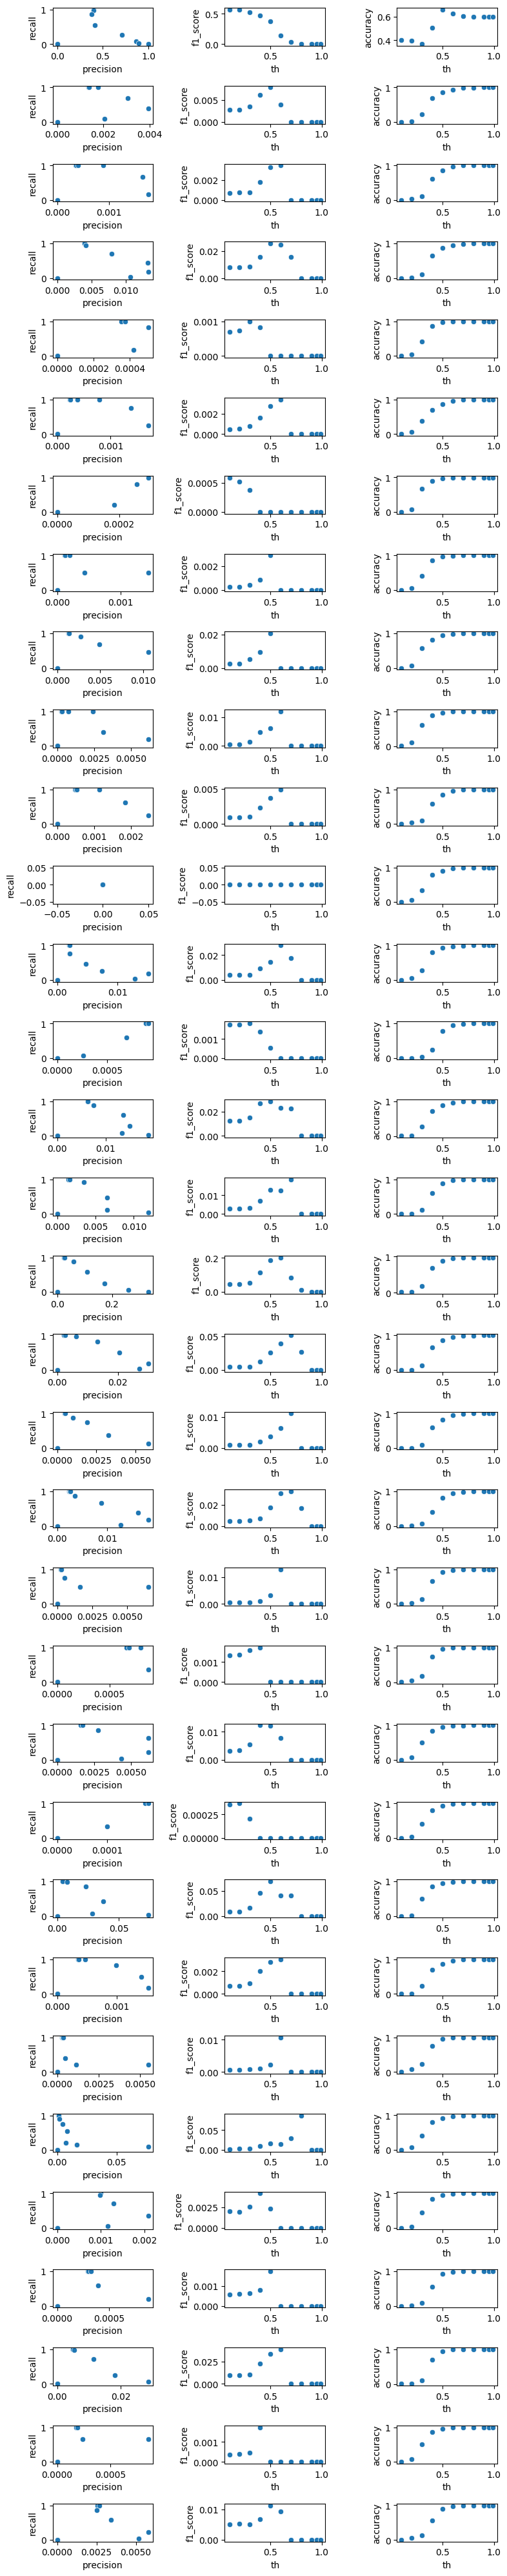

In [58]:
test_metrics_df = evaluate_model(model, thresholds, test_data_loader)
plot_metrics(test_metrics_df)